In [3]:
target_property_list = ['voltage', 'energy', 'conductivity', 'columbic_efficiency']

In [4]:
gnn_data = pd.read_csv(f'/content/drive/MyDrive/pre-processed2/data0.csv')


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize R^2 score dictionary
r2_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}
valid_target_properties = []

# Main loop
for target_property in target_property_list:
    try:
        df1 = pd.read_excel(f'/content/drive/MyDrive/pre-processed2/{target_property}.xlsx')
    except Exception as e:
        print(f"Failed to load data for {target_property}: {e}")
        continue

    avg_df = df1.groupby('jid')['Value'].mean().reset_index()
    avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

    merged_df = pd.merge(avg_df, gnn_data, left_on='jid', right_on='id')
    merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()

    # Ensure enough data
    if merged_df.shape[0] < 10:
        print(f"Skipping {target_property} due to insufficient data ({merged_df.shape[0]} rows).")
        continue

    # Extract features and target
    X = merged_df.drop(columns=['Value', 'id', 'jid'])
    X = X.select_dtypes(include=[np.number])  # only numeric features
    y = merged_df['Value'].values

    if X.shape[0] != len(y):
        print(f"Skipping {target_property} due to X/y shape mismatch.")
        continue

    # Normalize features for MLP/KNN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

    # Store valid target property for plotting
    valid_target_properties.append(target_property)

    # Train and evaluate models
    models = {
        "Linear Regression": LinearRegression(),
        "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores[name].append(r2)

        print(f"{name} R² for {target_property}: {r2:.4f}")


Linear Regression R² for voltage: -0.8413
MLP Regressor R² for voltage: 0.4263
Random Forest Regressor R² for voltage: 0.7345
KNN Regressor R² for voltage: 0.6180
Decision Tree Regressor R² for voltage: 0.6461
Linear Regression R² for energy: -20.2448
MLP Regressor R² for energy: -5.9683
Random Forest Regressor R² for energy: -1.9512
KNN Regressor R² for energy: 0.3180
Decision Tree Regressor R² for energy: -9.6368
Linear Regression R² for conductivity: -113222.3899
MLP Regressor R² for conductivity: -13588.8513
Random Forest Regressor R² for conductivity: -150875.5033
KNN Regressor R² for conductivity: -90390.3019
Decision Tree Regressor R² for conductivity: -4854.5360
Linear Regression R² for columbic_efficiency: -2.3236
MLP Regressor R² for columbic_efficiency: -4.6719
Random Forest Regressor R² for columbic_efficiency: 0.3668
KNN Regressor R² for columbic_efficiency: -0.6953
Decision Tree Regressor R² for columbic_efficiency: -0.7409


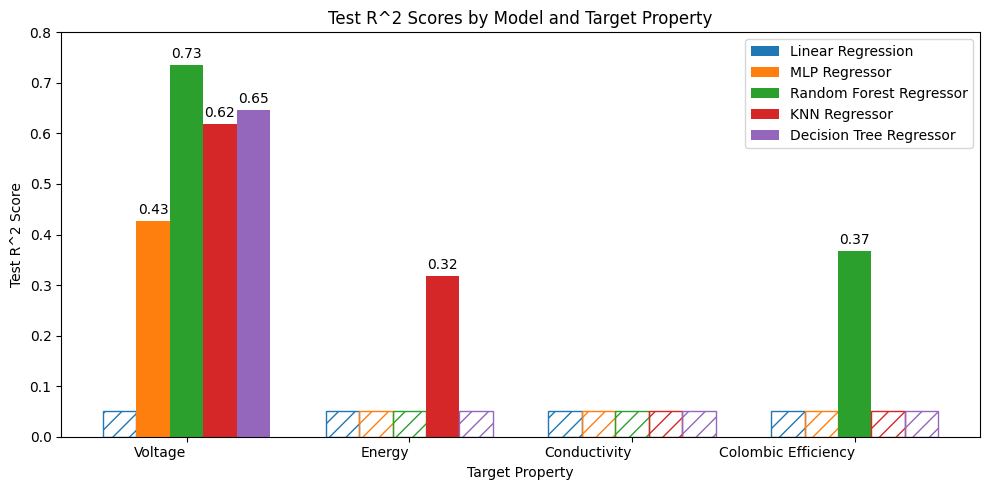

In [19]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_r2_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_r2_scores(scores)
    rects_visible = ax.bar(x + offset, visible, width, label=label, color=color)

    # Draw hatched rectangles for invalid scores at fixed height
    hatch_height = 0.05  # fixed height for placeholder
    for i, invalid in enumerate(is_invalid):
        if invalid:
            ax.bar(x[i] + offset, hatch_height, width,
                   fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, r2_scores["Linear Regression"], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, r2_scores["MLP Regressor"], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, r2_scores["Random Forest Regressor"], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, r2_scores["KNN Regressor"], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, r2_scores["Decision Tree Regressor"], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test R^2 Score')
ax.set_title('Test R^2 Scores by Model and Target Property')
ax.set_xticks(x)
ax.set_xticklabels(['Voltage','Energy','Conductivity','Colombic Efficiency'], rotation=0, ha='right')
ax.legend()
ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()
